In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [37]:
defending_csv = "cleaned_data/defending_cleaned.csv"
passing_csv = "cleaned_data/passing_cleaned.csv"
standard_csv = "cleaned_data/standard_cleaned.csv"

df_def = pd.read_csv(defending_csv)
df_pass = pd.read_csv(passing_csv)
df_std = pd.read_csv(standard_csv)

In [38]:
print("Defending columns:", df_def.columns.tolist())
print("Passing columns:", df_pass.columns.tolist())
print("Standard columns:", df_std.columns.tolist())

Defending columns: ['Rk', 'Player', 'Nation', 'Pos', 'Squad', 'Comp', 'Age', 'Born', '90s', 'Tkl', 'TklW', 'Def 3rd', 'Mid 3rd', 'Att 3rd', 'DribTkl', 'Att', 'Tkl%', 'Lost', 'Blocks', 'Sh', 'Pass', 'Int', 'Tkl+Int', 'Clr', 'Err', 'Matches', 'Season', 'Interceptions/90', 'Tackles/90']
Passing columns: ['Rk', 'Player', 'Nation', 'Pos', 'Squad', 'Comp', 'Age', 'Born', '90s', 'Cmp_Total', 'Att_Total', 'Cmp%_Total', 'TotDist', 'PrgDist', 'Cmp_Short', 'Att_Short', 'Cmp%_Short', 'Cmp_Medium', 'Att_Medium', 'Cmp%_Medium', 'Cmp_Long', 'Att_Long', 'Cmp%_Long', 'Ast', 'xAG', 'xA', 'A-xAG', 'KP', '1/3', 'PPA', 'CrsPA', 'PrgP', 'Matches', 'Season', 'Cmp_Total/90', 'Cmp_Short/90', 'Cmp_Medium/90', 'Cmp_Long/90', 'Att_Total/90', 'Att_Short/90', 'Att_Medium/90', 'Att_Long/90']
Standard columns: ['Rk', 'Player', 'Nation', 'Pos', 'Squad', 'Comp', 'Age', 'Born', 'MP', 'Starts', 'Min', '90s', 'Gls', 'Ast', 'G+A', 'G-PK', 'PK', 'PKatt', 'CrdY', 'CrdR', 'xG', 'npxG', 'xAG', 'npxG+xAG', 'PrgC', 'PrgP', 'PrgR

In [39]:
for df in [df_def, df_pass, df_std]:
    if 'Competition' in df.columns:
        df.rename(columns={'Competition': 'Comp'}, inplace=True)

In [40]:
for df in [df_def, df_pass, df_std]:
    if 'Competition' in df.columns:
        df.rename(columns={'Competition': 'Comp'}, inplace=True)
    if 'Age' in df.columns:
        df['Age'] = pd.to_numeric(df['Age'], errors='coerce')

In [41]:
merge_keys = ['Player', 'Season', 'Nation', 'Pos', 'Squad', 'Comp', 'Age']

# Merge defending + passing
df_merged = pd.merge(df_def, df_pass, on=merge_keys, suffixes=('_def', '_pass'), how='inner')
# Merge with standard
df_merged = pd.merge(df_merged, df_std, on=merge_keys, suffixes=('', '_std'), how='inner')

print("Merged shape:", df_merged.shape)

Merged shape: (19564, 95)


In [42]:
drop_cols = ['Nation', 'Comp', 'Born']  # Add more as needed
df_final = df_merged.drop(columns=[col for col in drop_cols if col in df_merged.columns])

In [43]:
# Identify non-numeric columns to exclude
non_numeric = ['Player', 'Season', 'Pos', 'Squad', 'Age']
feature_cols = [col for col in df_final.columns if col not in non_numeric and pd.api.types.is_numeric_dtype(df_final[col])]

# Final feature matrix for clustering
X = df_final[feature_cols].copy()

In [44]:
# Check for inf/-inf and replace with NaN
X.replace([np.inf, -np.inf], np.nan, inplace=True)

# Option 1: Drop rows with NaN (if you want only complete cases)
X = X.dropna()

# Option 2: Or fill NaN with 0 or column mean (choose what makes sense for your use case)
# X = X.fillna(0)
# X = X.fillna(X.mean())

# Now scale
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns, index=X.index)

print(X.isnull().sum())
print(np.isinf(X).sum())

Born_def          0
90s_def           0
Tkl               0
TklW              0
Def 3rd           0
                 ..
xG_per90          0
xAG_per90         0
xG+xAG_per90      0
npxG_per90        0
npxG+xAG_per90    0
Length: 68, dtype: int64
Born_def          0
90s_def           0
Tkl               0
TklW              0
Def 3rd           0
                 ..
xG_per90          0
xAG_per90         0
xG+xAG_per90      0
npxG_per90        0
npxG+xAG_per90    0
Length: 68, dtype: int64


In [45]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns, index=X.index)

In [56]:
def prepare_player_clustering_df(
    defending_csv="cleaned_data/defending_cleaned.csv",
    passing_csv="cleaned_data/passing_cleaned.csv",
    standard_csv="cleaned_data/standard_cleaned.csv",
    drop_cols=None,
    scale_method="zscore"
):
    """
    Loads, merges, and prepares player-level stats for clustering.

    Returns:
        df_final: DataFrame with identifiers and features
        X_scaled: Standardized feature matrix (for clustering)
    """
    # Load
    df_def = pd.read_csv(defending_csv)
    df_pass = pd.read_csv(passing_csv)
    df_std = pd.read_csv(standard_csv)

    # Harmonize column names and ensure Age is numeric
    for df in [df_def, df_pass, df_std]:
        if 'Competition' in df.columns:
            df.rename(columns={'Competition': 'Comp'}, inplace=True)
        if 'Age' in df.columns:
            df['Age'] = pd.to_numeric(df['Age'], errors='coerce')

    merge_keys = ['Player', 'Season', 'Nation', 'Pos', 'Squad', 'Comp', 'Age']

    # Merge
    df_merged = pd.merge(df_def, df_pass, on=merge_keys, suffixes=('_def', '_pass'), how='inner')
    df_merged = pd.merge(df_merged, df_std, on=merge_keys, suffixes=('', '_std'), how='inner')

    # Drop unwanted columns
    if drop_cols is None:
        drop_cols = ['Nation', 'Comp', 'Born']
    df_final = df_merged.drop(columns=[col for col in drop_cols if col in df_merged.columns])

     # Identify features
    non_numeric = ['Player', 'Season', 'Pos', 'Squad', 'Age']
    feature_cols = [col for col in df_final.columns if col not in non_numeric and pd.api.types.is_numeric_dtype(df_final[col])]

    # Clean inf/-inf and NaN values before scaling
    X = df_final[feature_cols].copy()
    X.replace([np.inf, -np.inf], np.nan, inplace=True)
    X = X.fillna(0)  # or use X = X.fillna(0) or X = X.fillna(X.mean()) if you prefer

    # Standardize
    from sklearn.preprocessing import StandardScaler, MinMaxScaler
    scaler = StandardScaler() if scale_method == "zscore" else MinMaxScaler()
    X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=feature_cols, index=X.index)

    # Optionally, align df_final to X (if you dropped rows)
    df_final = df_final.loc[X.index]

    return df_final, X_scaled

In [57]:
df_final, X_scaled = prepare_player_clustering_df()

print(df_final[['Player', 'Season', 'Squad', 'Pos']].head())
print(X_scaled.head())

                Player     Season           Squad    Pos
0  Patrick van Aanholt  2017-2018  Crystal Palace     DF
1       Rolando Aarons  2017-2018   Newcastle Utd  MF,FW
2       Rolando Aarons  2017-2018   Hellas Verona  MF,FW
3        Ignazio Abate  2017-2018           Milan     DF
4      Aymen Abdennour  2017-2018       Marseille     DF
   Born_def   90s_def       Tkl      TklW   Def 3rd   Mid 3rd   Att 3rd  \
0 -0.897145  0.930708  1.206393  1.434737  1.619224  0.714042  0.145572   
1  0.104633 -1.158368 -0.798840 -0.661158 -0.622269 -0.793173 -0.813773   
2  0.104633 -0.773538 -0.379140 -0.361744 -0.536057 -0.470198  0.785135   
3 -1.698568 -0.223782 -0.052707  0.311936 -0.018790  0.068093 -0.493991   
4 -1.097501 -0.791864 -0.658940 -0.736011 -0.449846 -0.685515 -0.813773   

        Att      Tkl%      Lost  ...  Gls_per90  Ast_per90  G+A_per90  \
0  0.630360  0.371892  0.512042  ...   0.326684  -0.133999   0.115623   
1 -0.705509  1.133107 -0.776944  ...  -0.383676  -0.255654  -

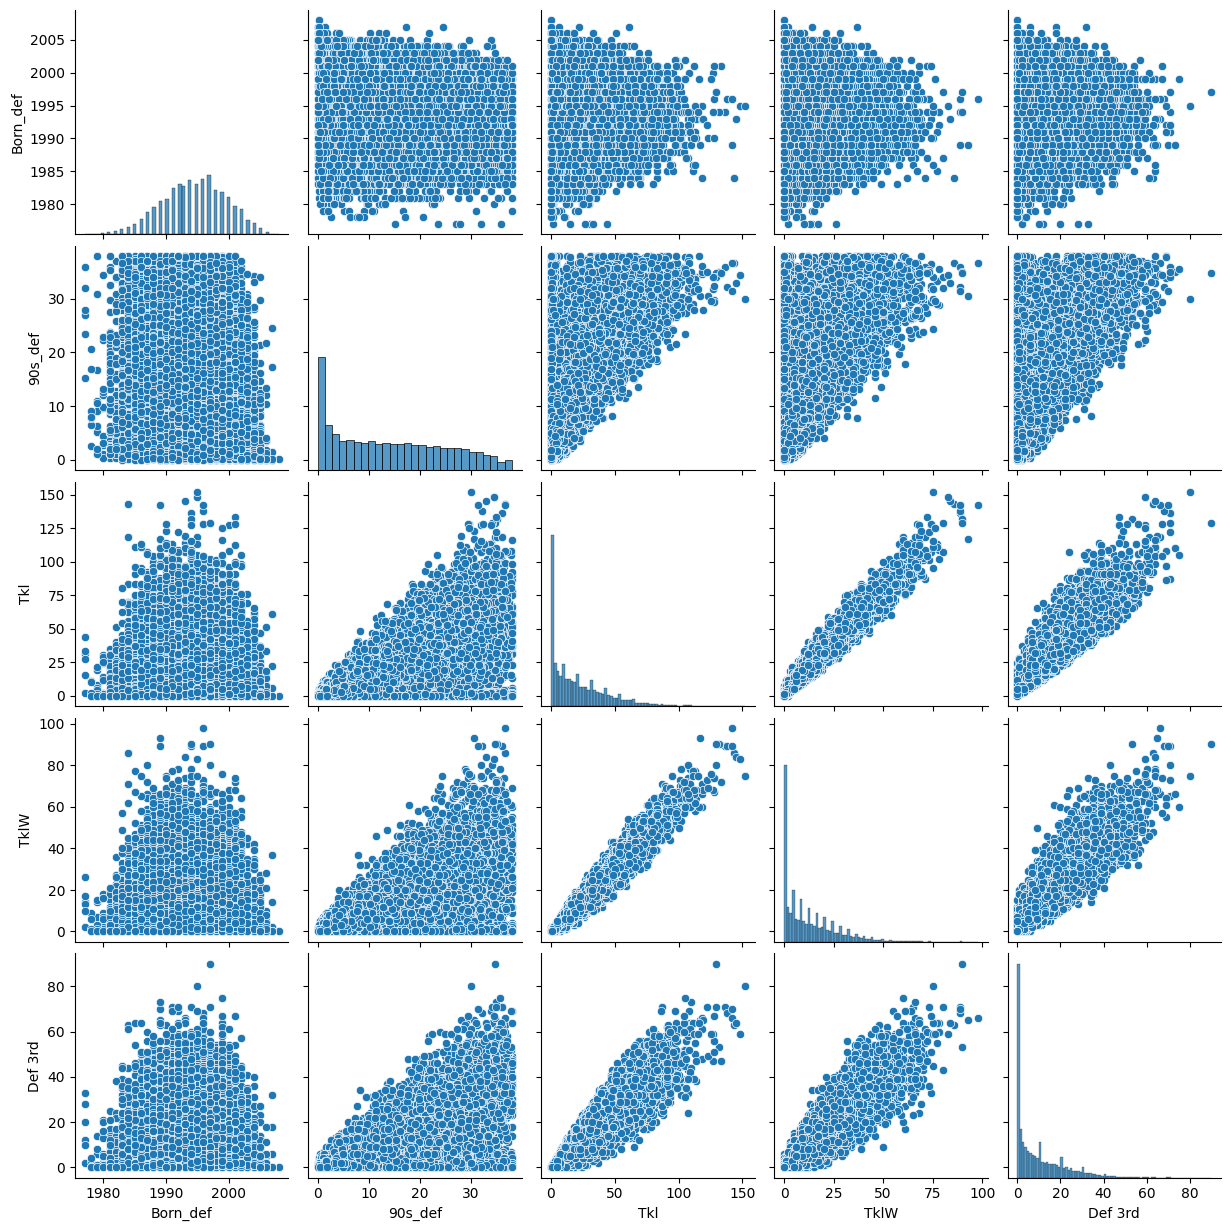

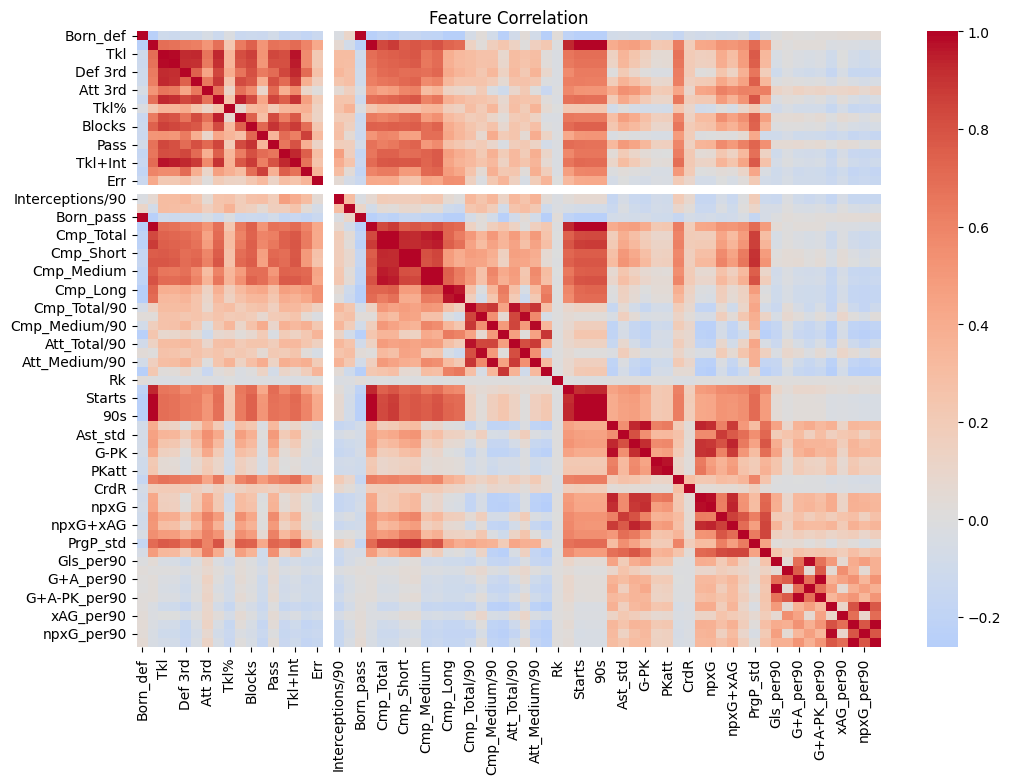

In [58]:
# Pairplot of a few features
sns.pairplot(df_final, vars=X_scaled.columns[:5])
plt.show()

# Correlation heatmap
plt.figure(figsize=(12,8))
sns.heatmap(X_scaled.corr(), cmap='coolwarm', center=0)
plt.title("Feature Correlation")
plt.show()

In [59]:
from sklearn.cluster import KMeans

# Choose number of clusters (k)
k = 6  #using 5 for now

kmeans = KMeans(n_clusters=k, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

In [60]:
df_final['cluster'] = clusters

In [61]:
cluster_profiles = df_final.groupby('cluster')[X_scaled.columns].mean()
print(cluster_profiles)

            Born_def    90s_def        Tkl       TklW    Def 3rd    Mid 3rd  \
cluster                                                                       
0        1998.727273   0.113636   0.181818   0.136364   0.000000   0.090909   
1        1993.823445  15.238319  27.371240  16.679646  13.892460  10.609806   
2        1991.239241  28.785570   0.763291   0.416456   0.741772   0.018987   
3        1993.358781  27.876546  53.920174  32.986067  28.222351  20.869666   
4        1993.887140  23.596808  23.912320  14.188399   7.486511  10.657824   
5        1995.791348   3.822664   4.981043   2.986025   2.188358   2.015555   

          Att 3rd        Att       Tkl%       Lost  ...  Gls_per90  Ast_per90  \
cluster                                             ...                         
0        0.090909   0.136364   4.545455   0.090909  ...   3.377273   5.070909   
1        2.868974  26.503914  47.777544  14.232180  ...   0.063496   0.072283   
2        0.002532   1.722785  27.546582   1

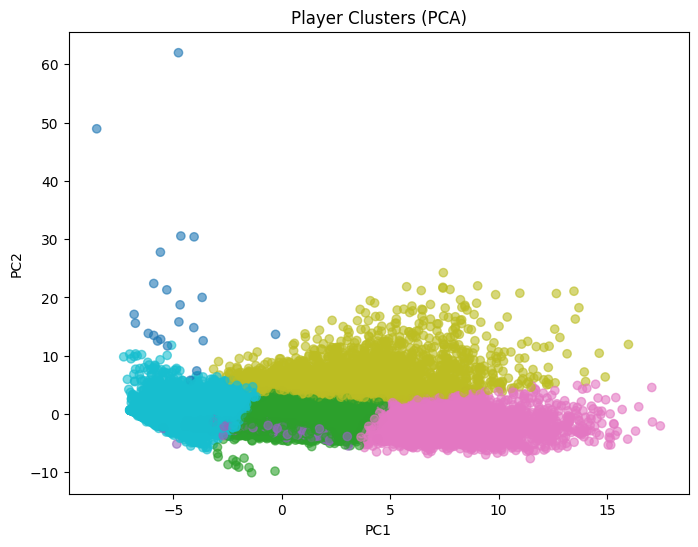

In [62]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
plt.figure(figsize=(8,6))
plt.scatter(X_pca[:,0], X_pca[:,1], c=clusters, cmap='tab10', alpha=0.6)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Player Clusters (PCA)')
plt.show()

In [63]:
# Show first 10 players in each cluster
for c in sorted(df_final['cluster'].unique()):
    print(f"\nCluster {c}:")
    print(df_final[df_final['cluster'] == c][['Player', 'Season', 'Squad', 'Pos']].head(10))


Cluster 0:
                       Player     Season            Squad    Pos
1507             Linton Maina  2017-2018      Hannover 96     MF
1628          Alexander Meier  2017-2018   Eint Frankfurt     FW
3558             Borja Garcés  2018-2019  Atlético Madrid     FW
3670            Metehan Güçlü  2018-2019        Paris S-G     MF
4436   Georges-Kévin N'Koudou  2018-2019        Tottenham     FW
5831        Christian Celesia  2019-2020           Torino     DF
6699               Jack Lahne  2019-2020           Amiens     FW
6809              Iker Losada  2019-2020       Celta Vigo  MF,FW
9383              Habib Keita  2020-2021             Lyon     MF
10877         Nicola Zalewski  2020-2021             Roma     MF

Cluster 1:
                  Player     Season       Squad    Pos
3          Ignazio Abate  2017-2018       Milan     DF
6            Mehdi Abeid  2017-2018       Dijon     MF
9           Amir Abrashi  2017-2018    Freiburg     MF
11        Afriyie Acquah  2017-2018      

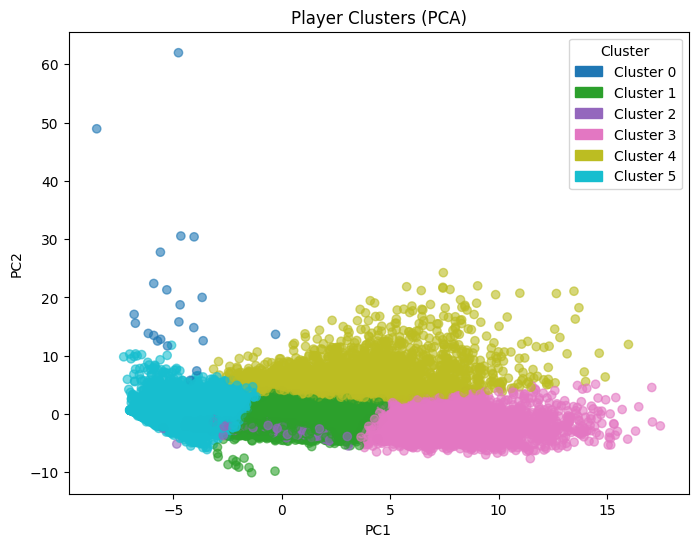

In [ ]:
import matplotlib.patches as mpatches

plt.figure(figsize=(8,6))
scatter = plt.scatter(X_pca[:,0], X_pca[:,1], c=clusters, cmap='tab10', alpha=0.6)

# Create legend: one color per cluster but must label better afterwards
handles = []
unique_clusters = np.unique(clusters)
cmap = plt.get_cmap('tab10', len(unique_clusters))  # <-- fixed here
for i, cluster_num in enumerate(unique_clusters):
    handles.append(mpatches.Patch(color=cmap(i), label=f'Cluster {cluster_num}'))

plt.legend(handles=handles, title="Cluster")
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Player Clusters (PCA)')
plt.show()

In [65]:
df_final.to_csv("cleaned_data/merged_player_data.csv", index=False)